<h1><center> Dow Jones Lasso Analysis </center></h1>

### Library Imports
We begin by importing the necessary Python libraries for this analysis. These include modules for data acquisition (`yfinance`), data manipulation (`pandas`, `numpy`), statistical modeling (`statsmodels`, `scikit-learn`), and visualization (`matplotlib`, `seaborn`). The libraries support tasks such as fetching financial data, preprocessing and splitting datasets, implementing Lasso regression, evaluating model performance, and generating insightful plots.

In [32]:
# Libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm # color scheme

### Data Loading and Preparation

The dataset is loaded from a merged CSV file (refer data cleaning folder) containing macroeconomic indicators and stock market indices. we replace long names with simpler, Python-friendly labels. 

In [52]:
# Load in the data "
data = pd.read_csv('merged_data.csv')
data.rename(columns={'CPALWE01USQ661N': 'CPI', 'S&P 500 ^GSPC': 'S&P_500', 'NASDAQ ^IXIC': 'NASDAQ', 'Dow Jones ^DJI':'Dow_Jones', 'RealInterestRate':'Real_IR', 'UnemploymentRate': 'Unemployment_Rate', 'FedFundsRate': 'Federal_Funds_Rate'}, inplace = True)
data.head(10)

,Date,S&P_500,NASDAQ,Dow_Jones,CPI,Real_IR,Unemployment_Rate,GDP_Growth,M2_Supply,Federal_Funds_Rate
0,1992-01-01,408.779999,620.210022,3223.399902,58.870052,3.198542,7.3,4.9,3398.6,4.03
1,1992-04-01,414.950012,578.679993,3359.100098,59.387717,3.789860,7.4,4.4,3434.1,3.73
2,1992-07-01,424.209991,580.830017,3393.800049,59.862244,3.353099,7.7,4.0,3407.1,3.25
3,1992-10-01,418.679993,605.169983,3226.300049,60.279252,2.728044,7.3,4.2,3413.8,3.10
4,1993-01-01,438.779999,696.340027,3310.000000,60.696260,3.267908,7.3,0.7,3455.2,3.02
5,1993-04-01,440.190002,661.419983,3427.550049,61.185166,2.774517,7.1,2.3,3438.6,2.96
6,1993-07-01,448.130005,704.700012,3539.469971,61.415239,2.591799,6.9,1.9,3450.7,3.06
7,1993-10-01,467.829987,779.260010,3680.590088,61.832248,2.398843,6.8,5.6,3449.1,2.99
8,1994-01-01,481.609985,800.469971,3978.360107,62.119840,2.772685,6.6,3.9,3502.8,3.05
9,1994-04-01,450.910004,733.840027,3681.689941,62.551227,3.659183,6.4,5.5,3507.2,3.56


### Defining Variables for Lasso Regression

We assigned key macroeconomic indicators such as CPI, real interest rate, unemployment rate, GDP growth, money supply (M2), and the federal funds rate as the independent variables. 

The dependent variable is set as the Dow Jones index (which we are essentially trying to predict).

These variables are then separated into feature matrix `x` and target vector `y` for use in the Lasso regression model.

In [34]:
# determining independent and dependent variables used in lasso
independent_variables = ['CPI', 'Real_IR', 'Unemployment_Rate', 'GDP_Growth', 'M2_Supply', 'Federal_Funds_Rate']
dependent_variable = ['Dow_Jones']

x = data[independent_variables]
y = data[dependent_variable]

### Lasso Regression Workflow

To model the relationship between macroeconomic indicators and the Dow Jones index, we perform Lasso regression with the following steps:

1. **Train-Test Split**: The dataset is divided into training and testing sets using an 80/20 split without shuffling, preserving the temporal sequence of observations — which is important for time-series-like data.
2. **Feature Scaling**: Standardization is applied to the independent variables using `StandardScaler` to normalize the input data, which is essential for Lasso regression since it is sensitive to the scale of input features.
3. **Model Training**: A Lasso regression model with 5-fold cross-validation is fit to the scaled training data to determine the optimal regularization strength (lambda). The `.ravel()` method is used on the target vector to suppress shape-related warnings.
4. **Prediction and Evaluation**: The trained model is used to predict the test set outcomes. Root Mean Squared Error (RMSE) and Mean Squared Error (MSE) are computed to evaluate model performance.
5. **Results Summary**: The optimal lambda value and the learned coefficients for each independent variable are displayed, highlighting the variables that most influence the prediction of the Dow Jones index.


In [35]:
# splitting into test_train, NO SHUFFLE (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)

In [36]:
# Transform x values into standard normal (mean = 0, std = 1)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [37]:
# running lasso with 5 folds on training set
lasso = LassoCV(cv = 5, random_state = 42)
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

In [38]:
# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
mse = rmse ** 2

In [39]:
# Results
print(f'Test RMSE: {rmse:.2f}')
print(f'Optimal Lambda: {optimal_lambda:.2f}')
for i in range(len(x.columns)):
    variable = x.columns[i]
    coef = coefficient[i]
    print(f'{variable}: {coef:.2f}')

Test RMSE: 6101.33
Optimal Lambda: 11.71
CPI: 2747.59
Real_IR: -0.00
Unemployment_Rate: -1548.84
GDP_Growth: 368.18
M2_Supply: 1619.06
Federal_Funds_Rate: 0.00


### Interpretation of Lasso Regression Results

The Lasso regression model yields a **test RMSE of 6101.33**, indicating the average deviation between the predicted and actual Dow Jones values on the test set. While the magnitude is relatively high, it provides a baseline measure of model performance in this macroeconomic context.

The model selected an **optimal lambda (regularization strength) of 11.71**, which penalizes less relevant features and helps prevent overfitting. Based on the learned coefficients:

- **CPI (2747.59)** and **M2 Supply (1619.06)** show the strongest positive influence on the Dow Jones index, suggesting that inflationary trends and money supply expansion are positively associated with stock market performance.
- **Unemployment Rate (-1548.84)** exhibits a strong negative impact, aligning with economic intuition that higher unemployment

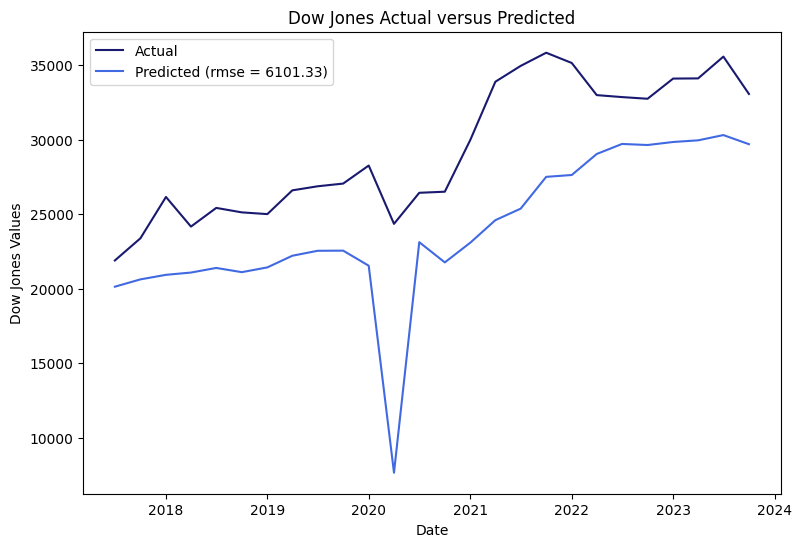

In [40]:
# Actual Versus Predicted Lasso Model
data['Date'] = pd.to_datetime(data['Date']) # converting date to pandas datetime format
dates = data['Date'].iloc[x_test.index] # gets a datatype of all dates based on index

plt.figure(figsize = (9,6))
plt.plot(dates, y_test.values, label = 'Actual', color = 'midnightblue')
plt.plot(dates, y_pred, label = 'Predicted (rmse = 6101.33)', color = 'royalblue')
plt.title('Dow Jones Actual versus Predicted')
plt.xlabel('Date')
plt.ylabel('Dow Jones Values')
plt.legend()
plt.show()

### Visualization: Actual vs Predicted Dow Jones Index

The plot above illustrates the performance of the Lasso regression model in predicting the Dow Jones Industrial Average (DJIA) over time. The dark blue line represents the **actual observed values** of the index, while the lighter blue line depicts the **model’s predictions** based on macroeconomic inputs.

Although the model captures the general trend in the index, there is a noticeable underestimation during periods of high volatility, especially seen around the 2020 COVID-19 market crash. The test RMSE of **6101.33** reflects the average prediction error in Dow Jones points, substantial in absolute terms.

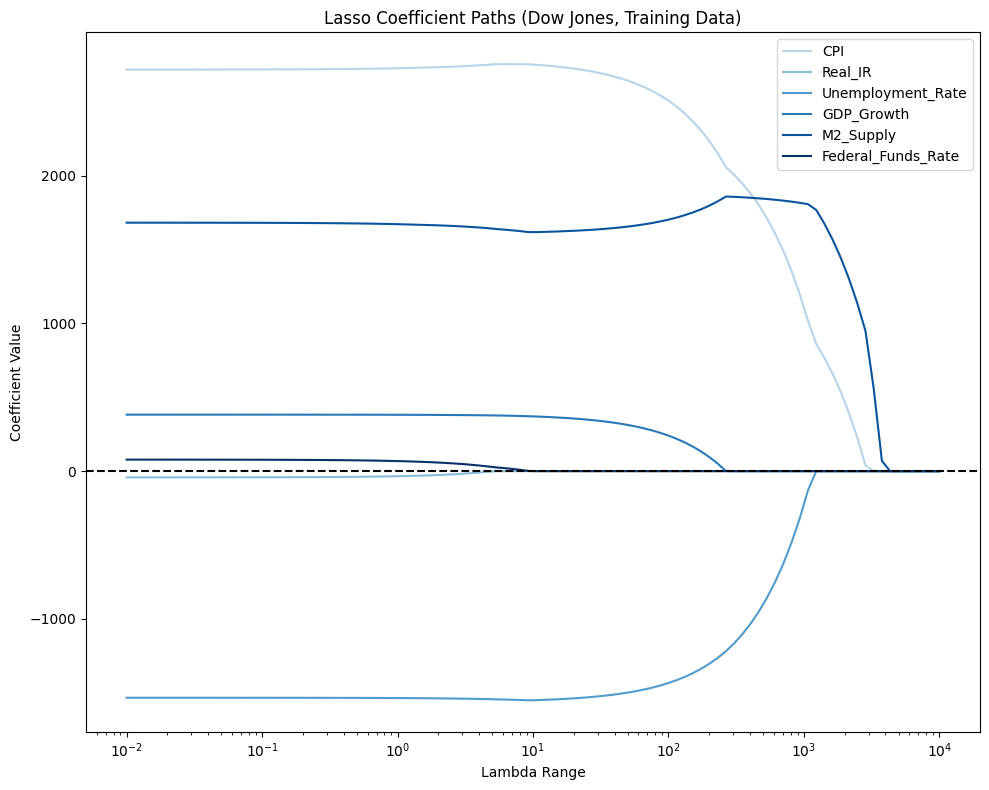

In [41]:
# Plotting Lasso Coefficient 

# colors
colors = cm.Blues(np.linspace(0.3, 1, len(x.columns)))  # light to dark blue

# large range of lambda values
lambdas = np.logspace(-2, 4, 100)

# Calculating the coefficients
coefs = []
for lam in lambdas:
    lasso = Lasso(alpha = lam, max_iter = 10000)
    lasso.fit(x_train_scaled, y_train)
    coefs.append(lasso.coef_)

plt.figure(figsize=(10, 8))
for i in range(len(x.columns)):  
    coef_path = [coefs[j][i] for j in range(len(coefs))] 
    plt.plot(lambdas, coef_path, label = x.columns[i], color = colors[i])

plt.xscale('log')
plt.xlabel('Lambda Range')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficient Paths (Dow Jones, Training Data)')
plt.axhline(0, color='black', linestyle='--')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

### Lasso Coefficient Paths (Training Data)

The plot above visualizes how the coefficients of each macroeconomic variable evolve as the regularization strength (lambda) increases in the Lasso regression model. 

- The **x-axis** represents the lambda values on a logarithmic scale — from very small (minimal regularization) to large (strong regularization).
- The **y-axis** shows the magnitude of the regression coefficients for each variable.

As lambda increases, the model enforces greater shrinkage on the coefficients. Variables like **M2 Money Supply**, **Unemployment Rate**, and **CPI** retain significant influence the longest before eventually being reduced toward zero. This suggests they are the most informative predictors for the Dow Jones index within the training data.

As lambda increases, M2 money supply, unemployment rate, and CPI are the three indicators with the largest coefficient values and persist the longest before shrinking to zero. This means they are the most important variables in predicting Dow Jones values. On the other hand, GDP growth, Federal Funds Rate, and Real Interest Rate begin with smaller magnitudes and are driven to zero much earlier, indicating they are less influential in the model’s predictions. This is similar to S&P 500 but it takes a larger value of lambda to drive these all to zero.

### Multiple Linear Regression (MLR) for Comparison

To benchmark the performance of the Lasso regression model, we also use a **Multiple Linear Regression (MLR)** approach with the same set of independent macroeconomic variables.

- A constant term is added to the predictor matrix to account for the intercept in the OLS model.
- The dataset is split into training and testing sets using an 80/20 ratio, with no shuffling to preserve temporal order.
- The Ordinary Least Squares (OLS) model is fit to the training data and used to predict values on the test set.
- Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) are calculated to evaluate performance.

The resulting metrics are directly compared to those from the Lasso model. This comparison helps assess whether the regularization and feature selection benefits of Lasso provide a tangible improvement over a standard linear regression approach in predicting the Dow Jones index.

In [42]:
# MLR for MSE comparison

independent_variables = ['CPI', 'Real_IR', 'Unemployment_Rate', 'GDP_Growth', 'M2_Supply', 'Federal_Funds_Rate']
dependent_variable = ['Dow_Jones']

x = data[independent_variables]
x_constant = sm.add_constant(x) # Adding a constant value of x
y = data[dependent_variable]
x_train, x_test, y_train, y_test = train_test_split(x_constant, y, test_size = .20, shuffle = False)

# Running OLS
model = sm.OLS(y_train, x_train).fit()
y_pred = model.predict(x_test)

mse_MLR = mean_squared_error(y_test, y_pred)
rmse_MLR = mse_MLR ** .5
print('MLR MSE:', mse_MLR, '\nLasso MSE:', mse)
print(rmse_MLR)

MLR MSE: 35638656.89952654 
Lasso MSE: 37226194.576148555
5969.812132682781


### Model Performance Comparison: MLR vs Lasso

The Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) from both models are compared to evaluate predictive performance:

- **MLR MSE:** 35,638,656.90  
- **Lasso MSE:** 37,226,194.58  
- **MLR RMSE:** 5,969.81  
- **Lasso RMSE:** 6,101.33  

The **Multiple Linear Regression (MLR)** model slightly outperforms the **Lasso regression** in terms of both MSE and RMSE on the test set. This indicates that, for this dataset, the full linear model with no regularization provides slightly better predictive accuracy than Lasso.

However, Lasso offers additional benefits such as **automatic variable selection** and **model simplicity** by shrinking less informative coefficients to zero. While it incurs a small trade-off in accuracy here, it can be especially useful in preventing overfitting or when dealing with multicollinearity.

Overall, the difference in performance is modest, suggesting that both models are viable, with the choice depending on the desired balance between interpretability, sparsity, and raw predictive power.

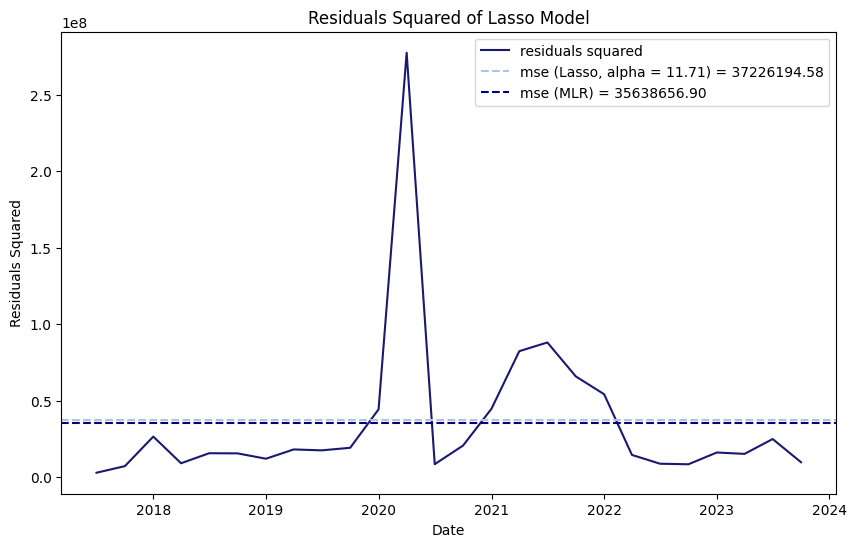

In [44]:
# Residuals (alpha = 1.5)
y_test_series =  y_test.squeeze() # convert to series, to calculate residuals
residuals_squared = (y_test_series - y_pred) ** 2

plt.figure(figsize = (10,6))
plt.plot(dates, residuals_squared, color = 'midnightblue', label = 'residuals squared')
plt.axhline(mse, color = 'lightsteelblue', label = 'mse (Lasso, alpha = 11.71) = 37226194.58', linestyle = '--')
plt.axhline(mse_MLR, color = 'navy', label = 'mse (MLR) = 35638656.90', linestyle = '--')
plt.xlabel('Date')
plt.ylabel('Residuals Squared')
plt.title('Residuals Squared of Lasso Model')
plt.legend()
plt.show()

### Residual Analysis of the Lasso Model

The plot above shows the **squared residuals** (prediction errors) of the Lasso regression model over time, along with horizontal reference lines representing the **Mean Squared Error (MSE)** for both Lasso and Multiple Linear Regression (MLR).

Key observations include:
- The **peak in squared residuals around 2020** reflects a large prediction error, likely due to the sharp market decline during the COVID-19 crash, which is difficult for macro-based models to anticipate.
- The **overall MSE values for Lasso (37.2M)** and MLR (35.6M) are relatively close, indicating that the regularization introduced by Lasso provided minimal predictive gain at the selected lambda of **11.71**.

Using the optimal lambda value of 11.71, we can see that MLR and Lasso MSE do not alter all that much. This implies that the lambda value did not offer much improvement if any at all

The only difference between MLR and Lasso is alpha and from our coefficient path graph we can see that around a lambda of 300, the only three remaning variables are M2 Money Supply, Unemployment Rate, and CPI. 

<b>Therefore, we will re-run our lasso using a lambda values of 300 and re-evaluate our model to see if this higher regularization over-penalized the model, or if these are the only three variables that matter.</b>


In [45]:
# running lasso with 5 folds on training set and alpha = 300
lasso = LassoCV(cv = 5, random_state = 42, alphas = [300])
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

In [46]:
# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
new_mse = rmse ** 2

In [47]:
# Results
print(f'Test RMSE: {rmse:.2f}')
print(f'Optimal Lambda: {optimal_lambda:.2f}')
for i in range(len(x.columns)):
    variable = x.columns[i]
    coef = coefficient[i]
    print(f'{variable}: {coef:.2f}')

Test RMSE: 6835.16
Optimal Lambda: 300.00
CPI: 2012.70
Real_IR: -0.00
Unemployment_Rate: -1172.87
GDP_Growth: 0.00
M2_Supply: 1857.20
Federal_Funds_Rate: -0.00


Compared to the earlier Lasso model (RMSE = 6101.33) and MLR (RMSE ≈ 5969.81), the **performance slightly worsened**, indicating that aggressive regularization may have **over-penalized the model** by discarding useful predictors.

However, this run confirms the results seen in the coefficient path plot: **CPI, M2 Supply, and Unemployment Rate** are consistently the most influential features. While this model is less accurate, it is much simpler still valuable when interpretability or model sparsity is prioritized.

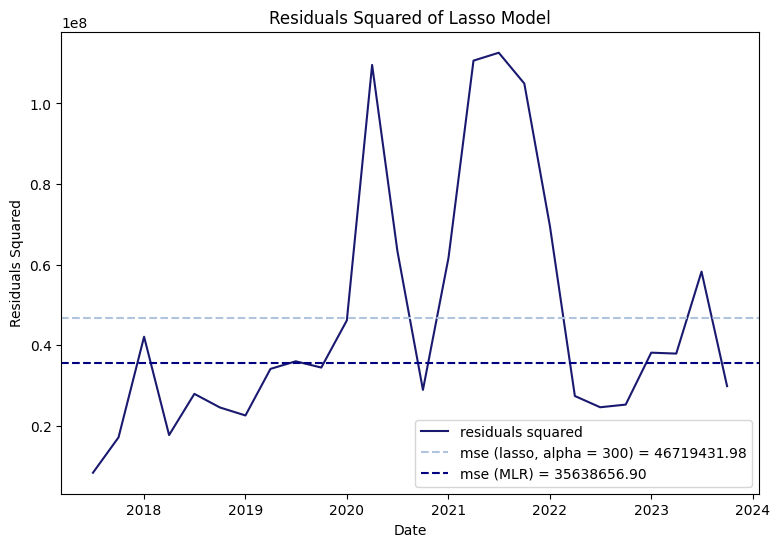

In [50]:
# Residuals
y_test_series =  y_test.squeeze() # convert to series, to calculate residuals
residuals_squared = (y_test_series - y_pred) ** 2

plt.figure(figsize = (9,6))
plt.plot(dates, residuals_squared, color = 'midnightblue', label = 'residuals squared')
plt.axhline(new_mse, color = 'lightsteelblue', label = 'mse (lasso, alpha = 300) = 46719431.98', linestyle = '--')
plt.axhline(mse_MLR, color = 'navy', label = 'mse (MLR) = 35638656.90', linestyle = '--')
plt.xlabel('Date')
plt.ylabel('Residuals Squared')
plt.title('Residuals Squared of Lasso Model')
plt.legend()
plt.show()

### 📉 Residuals Analysis: Lasso with α = 300

The graph illustrates the **squared residuals** from the Lasso regression model trained with a strong regularization parameter (α = 300), plotted over time. It also includes horizontal lines representing the **Mean Squared Error (MSE)** for both this Lasso model and the baseline **Multiple Linear Regression (MLR)** model.

Increasing the alpha value to 300 resulted in poorer model performance compared to multiple linear regression. Rather than enhancing generalization, the stronger regularization overly constrained the model, indicating that such a high degree of penalization was unnecessary in this case. While M2 Money Supply, Unemployment Rate, and CPI emerged as the most robust predictors—resisting shrinkage the longest—it doesn't imply that Federal Funds Rate, GDP Growth, and Real Interest Rate are entirely irrelevant to predicting the Dow Jones. Their coefficients being reduced to zero under strong regularization simply reflects that they may carry weaker or more context-dependent signals.

### 🔁 Testing Lasso with α = 0 to Match MLR

To demonstrate that **Lasso regression with α = 0** behaves equivalently to **Multiple Linear Regression (MLR)**, the model was retrained. This effectively removes any penalization on the coefficients.

- Warnings related to convergence or model fitting were suppressed to maintain a clean output.
- The Lasso model was trained using 5-fold cross-validation on the scaled training data.
- Predictions were made on the test set, and **Root Mean Squared Error (RMSE)** and **Mean Squared Error (MSE)** were calculated for comparison.

As expected, the **Lasso model with α = 0 produced the same MSE as the MLR model**, confirming their equivalence when no regularization is applied. This serves as a useful validation check for the behavior of the Lasso implementation.

In [51]:
# running lasso with 5 folds on training set and alpha = 0 to show that it is the same as MLR

# CHAT GPT REFRENCE - GET RID OF WARNINGS
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore')  

lasso = LassoCV(cv = 5, random_state = 42, alphas = [0])
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
new_mse = rmse ** 2
print('MLR MSE:', mse_MLR, '\nLasso MSE:', new_mse)

MLR MSE: 35638656.89952654 
Lasso MSE: 35638656.89953238


When the alpha is at zero, lasso is equal to Multiple Linear Regression. Confirmed with the same outputed MSE values. 

### Summary: Lasso Regression Insights

While Lasso did not drastically improve predictive performance compared to multiple linear regression, it was highly effective for feature selection. By increasing the regularization parameter (lambda), Lasso shrank the coefficients of less important variables (like GDP Growth, Federal Funds Rate, and Real Interest Rate) toward zero much earlier. This reveals that the most influential predictors of the Dow Jones index are M2 Money Supply, Unemployment Rate, and CPI, as they retained strong coefficient values the longest.

Thus, Lasso provides valuable insight into which macroeconomic variables contribute most to modeling the Dow Jones, even if the prediction error is not minimized.